# Phase 4: XAI Benchmarking
## Comparison of XAI Methods: SHAP, LIME, Integrated Gradients, Attention Maps
### Benchmark on: Fidelity, Sparsity, Interpretability

In [ ]:
# Install required packages for XAI benchmarking
%pip install lime captum 
%pip install torch torchvision

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# XAI Libraries
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from captum.attr import IntegratedGradients, LayerIntegratedGradients
from captum.attr import visualization as viz

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [3]:
# Load and prepare data
print("📊 Loading dataset...")

load_df = pd.read_excel("load_scenarios.xlsx")
cont_df = pd.read_csv("n1_contingency_balanced_filled_complete.csv")
cont_df = cont_df[cont_df['Scenario'] < 1000].reset_index(drop=True)

# Extract features
load_features = load_df[["P_mw", "Q_mvar"]].values
load_features = load_features.reshape(1000, 40)
load_features_expanded = np.repeat(load_features, 41, axis=0)

bus_cols = [col for col in cont_df.columns if col.startswith("V_bus_")]
line_cols = [col for col in cont_df.columns if col.startswith("Loading_line_")]
voltages = cont_df[bus_cols].values.astype(np.float32)
line_flows = cont_df[line_cols].values.astype(np.float32)

# Combine features
X = np.concatenate([load_features_expanded, voltages, line_flows], axis=1)
y = cont_df['Severity'].values.astype(np.int64)

# Feature names
feature_names = []
for i in range(20):
    feature_names.extend([f"P_load_{i}", f"Q_load_{i}"])
feature_names.extend([f"V_bus_{i}" for i in range(len(bus_cols))])
feature_names.extend([f"Loading_line_{i}" for i in range(len(line_cols))])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape: {X.shape}")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

📊 Loading dataset...
Dataset shape: (41000, 111)
Training set: (32800, 111), Test set: (8200, 111)
Class distribution - Train: [18716 14084], Test: [4679 3521]
Dataset shape: (41000, 111)
Training set: (32800, 111), Test set: (8200, 111)
Class distribution - Train: [18716 14084], Test: [4679 3521]


In [6]:
# Define PyTorch model for Integrated Gradients
class PowerSystemClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(PowerSystemClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Train PyTorch model
print("🤖 Training PyTorch model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create model
model = PowerSystemClassifier(X_train_scaled.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
model.train()
for epoch in range(100):  # Reduced epochs for faster execution
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# Evaluate PyTorch model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    pytorch_accuracy = (predicted == y_test_tensor).float().mean().item()
    print(f"PyTorch Model Accuracy: {pytorch_accuracy:.4f}")

# Train sklearn model for SHAP and LIME
print("🤖 Training sklearn model...")
sklearn_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
sklearn_model.fit(X_train_scaled, y_train)
sklearn_accuracy = accuracy_score(y_test, sklearn_model.predict(X_test_scaled))
print(f"Sklearn Model Accuracy: {sklearn_accuracy:.4f}")

🤖 Training PyTorch model...
Using device: cpu
Epoch [10/100], Loss: 0.6234
Epoch [10/100], Loss: 0.6234
Epoch [20/100], Loss: 0.5150
Epoch [20/100], Loss: 0.5150
Epoch [30/100], Loss: 0.3793
Epoch [30/100], Loss: 0.3793
Epoch [40/100], Loss: 0.2736
Epoch [40/100], Loss: 0.2736
Epoch [50/100], Loss: 0.2090
Epoch [50/100], Loss: 0.2090
Epoch [60/100], Loss: 0.1638
Epoch [60/100], Loss: 0.1638
Epoch [70/100], Loss: 0.1311
Epoch [70/100], Loss: 0.1311
Epoch [80/100], Loss: 0.1069
Epoch [80/100], Loss: 0.1069
Epoch [90/100], Loss: 0.0883
Epoch [90/100], Loss: 0.0883
Epoch [100/100], Loss: 0.0764
PyTorch Model Accuracy: 0.9790
🤖 Training sklearn model...
Epoch [100/100], Loss: 0.0764
PyTorch Model Accuracy: 0.9790
🤖 Training sklearn model...
Sklearn Model Accuracy: 0.9987
Sklearn Model Accuracy: 0.9987


In [9]:
# Select evaluation samples
print("🎯 Selecting evaluation samples...")

# Increase samples for more robust benchmarking
n_samples = min(500, len(X_test_scaled))  # Increased from 100 to 500
eval_indices = np.random.choice(len(X_test_scaled), size=n_samples, replace=False)
X_eval = X_test_scaled[eval_indices]
y_eval = y_test[eval_indices]

print(f"Selected {n_samples} samples for evaluation")
print(f"Evaluation set class distribution: {np.bincount(y_eval)}")

# For computational efficiency, we'll use subsets for different methods
shap_samples = min(100, n_samples)  # SHAP on 100 samples
lime_samples = min(100, n_samples)  # LIME on 100 samples  
ig_samples = min(200, n_samples)    # Integrated Gradients on 200 samples
attention_samples = min(200, n_samples)  # Attention on 200 samples

print(f"Method-specific sample sizes:")
print(f"  SHAP: {shap_samples} samples")
print(f"  LIME: {lime_samples} samples") 
print(f"  Integrated Gradients: {ig_samples} samples")
print(f"  Gradient Attention: {attention_samples} samples")

🎯 Selecting evaluation samples...
Selected 500 samples for evaluation
Evaluation set class distribution: [281 219]
Method-specific sample sizes:
  SHAP: 100 samples
  LIME: 100 samples
  Integrated Gradients: 200 samples
  Gradient Attention: 200 samples


In [10]:
# Method 1: SHAP Explanations
print("🔍 Generating SHAP explanations...")

# SHAP for sklearn model with increased samples
explainer_shap = shap.Explainer(sklearn_model, X_train_scaled[:200])  # Increased background samples
shap_values = explainer_shap(X_eval[:shap_samples])  # Use variable sample size

# Extract SHAP values for positive class
if len(shap_values.values.shape) == 3:  # Multi-class output
    shap_attributions = shap_values.values[:, :, 1]  # Class 1 (unstable)
else:
    shap_attributions = shap_values.values

print(f"SHAP attributions shape: {shap_attributions.shape}")
print(f"✅ SHAP explanations generated for {len(shap_attributions)} samples")

🔍 Generating SHAP explanations...
SHAP attributions shape: (100, 111)
✅ SHAP explanations generated for 100 samples
SHAP attributions shape: (100, 111)
✅ SHAP explanations generated for 100 samples


In [12]:
# Method 2: LIME Explanations
print("🔍 Generating LIME explanations...")

# LIME explainer
explainer_lime = LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    class_names=['Stable', 'Unstable'],
    mode='classification'
)

# Generate LIME explanations for increased subset
lime_attributions = []

print(f"Generating LIME explanations for {lime_samples} samples...")
for i in range(lime_samples):
    if (i + 1) % 10 == 0:  # Progress indicator
        print(f"  Progress: {i+1}/{lime_samples} samples completed")
        
    explanation = explainer_lime.explain_instance(
        X_eval[i], 
        sklearn_model.predict_proba,
        num_features=len(feature_names),
        num_samples=1000  # Increased samples for more stable explanations
    )
    
    # Extract feature importances
    feature_importance = dict(explanation.as_list())
    lime_attribution = np.zeros(len(feature_names))
    
    for j, feature_name in enumerate(feature_names):
        if feature_name in feature_importance:
            lime_attribution[j] = feature_importance[feature_name]
    
    lime_attributions.append(lime_attribution)

lime_attributions = np.array(lime_attributions)
print(f"LIME attributions shape: {lime_attributions.shape}")
print(f"✅ LIME explanations generated for {len(lime_attributions)} samples")

🔍 Generating LIME explanations...
Generating LIME explanations for 100 samples...
  Progress: 10/100 samples completed
  Progress: 20/100 samples completed
  Progress: 30/100 samples completed
  Progress: 40/100 samples completed
  Progress: 50/100 samples completed
  Progress: 60/100 samples completed
  Progress: 70/100 samples completed
  Progress: 80/100 samples completed
  Progress: 90/100 samples completed
  Progress: 100/100 samples completed
LIME attributions shape: (100, 111)
✅ LIME explanations generated for 100 samples


In [13]:
# Method 3: Integrated Gradients
print("🔍 Generating Integrated Gradients explanations...")

# Integrated Gradients for PyTorch model
ig = IntegratedGradients(model)

# Convert evaluation samples to tensors with increased sample size
X_eval_tensor = torch.FloatTensor(X_eval[:ig_samples]).to(device)  # Increased samples
baseline = torch.zeros_like(X_eval_tensor[0]).unsqueeze(0).to(device)

# Generate attributions
ig_attributions = []
model.eval()

print(f"Generating Integrated Gradients for {ig_samples} samples...")
for i in range(len(X_eval_tensor)):
    if (i + 1) % 50 == 0:  # Progress indicator
        print(f"  Progress: {i+1}/{len(X_eval_tensor)} samples completed")
        
    input_tensor = X_eval_tensor[i].unsqueeze(0)
    
    # Get prediction for target class
    with torch.no_grad():
        output = model(input_tensor)
        target_class = torch.argmax(output, dim=1).item()
    
    # Compute integrated gradients with more steps for better accuracy
    attribution = ig.attribute(
        input_tensor,
        baseline,
        target=target_class,
        n_steps=100  # Increased from 50 to 100 for better accuracy
    )
    
    ig_attributions.append(attribution.squeeze().cpu().numpy())

ig_attributions = np.array(ig_attributions)
print(f"Integrated Gradients attributions shape: {ig_attributions.shape}")
print(f"✅ Integrated Gradients explanations generated for {len(ig_attributions)} samples")

🔍 Generating Integrated Gradients explanations...
Generating Integrated Gradients for 200 samples...
  Progress: 50/200 samples completed
  Progress: 100/200 samples completed
  Progress: 150/200 samples completed
  Progress: 200/200 samples completed
Integrated Gradients attributions shape: (200, 111)
✅ Integrated Gradients explanations generated for 200 samples


In [14]:
# Method 4: Attention Maps (Simplified - using gradient-based attention)
print("🔍 Generating gradient-based attention maps...")

# Simple gradient-based attention with increased samples
attention_attributions = []
model.eval()

# Use the tensor created for IG but potentially different sample size
X_attention_tensor = torch.FloatTensor(X_eval[:attention_samples]).to(device)

print(f"Generating gradient attention for {attention_samples} samples...")
for i in range(len(X_attention_tensor)):
    if (i + 1) % 50 == 0:  # Progress indicator
        print(f"  Progress: {i+1}/{len(X_attention_tensor)} samples completed")
        
    input_tensor = X_attention_tensor[i].unsqueeze(0)
    input_tensor.requires_grad_()
    
    # Forward pass
    output = model(input_tensor)
    target_class = torch.argmax(output, dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[0, target_class].backward()
    
    # Get gradients as attention
    attention = input_tensor.grad.squeeze().cpu().numpy()
    attention_attributions.append(attention)

attention_attributions = np.array(attention_attributions)
print(f"Attention attributions shape: {attention_attributions.shape}")
print(f"✅ Attention explanations generated for {len(attention_attributions)} samples")

🔍 Generating gradient-based attention maps...
Generating gradient attention for 200 samples...
  Progress: 50/200 samples completed
  Progress: 100/200 samples completed
  Progress: 150/200 samples completed
  Progress: 200/200 samples completed
Attention attributions shape: (200, 111)
✅ Attention explanations generated for 200 samples


In [15]:
# Benchmarking Metrics
print("📊 Computing benchmarking metrics...")

def compute_sparsity(attributions):
    """Compute sparsity as percentage of near-zero attributions"""
    threshold = 1e-4
    return np.mean(np.abs(attributions) < threshold) * 100

def compute_fidelity_approximation(attributions, X_eval_subset, model_func, top_k=10):
    """Approximate fidelity by removing top-k features and measuring prediction change"""
    fidelity_scores = []
    
    for i in range(len(attributions)):
        # Get original prediction
        original_pred = model_func(X_eval_subset[i:i+1])[0]
        
        # Find top-k important features
        top_features = np.argsort(np.abs(attributions[i]))[-top_k:]
        
        # Create perturbed input (set top features to mean)
        perturbed_input = X_eval_subset[i:i+1].copy()
        feature_means = np.mean(X_train_scaled, axis=0)
        perturbed_input[0, top_features] = feature_means[top_features]
        
        # Get perturbed prediction
        perturbed_pred = model_func(perturbed_input)[0]
        
        # Compute fidelity as prediction change
        fidelity = np.abs(original_pred - perturbed_pred)
        fidelity_scores.append(fidelity)
    
    return np.mean(fidelity_scores)

def compute_consistency(attributions):
    """Compute consistency as standard deviation across samples"""
    feature_importance_std = np.std(attributions, axis=0)
    return np.mean(feature_importance_std)

def compute_stability(attributions):
    """Compute stability as variance of attribution magnitudes"""
    attribution_magnitudes = np.mean(np.abs(attributions), axis=1)
    return np.std(attribution_magnitudes)

# Store methods with their respective sample sizes
methods = {
    'SHAP': {'attributions': shap_attributions, 'samples': len(shap_attributions)},
    'LIME': {'attributions': lime_attributions, 'samples': len(lime_attributions)}, 
    'Integrated Gradients': {'attributions': ig_attributions, 'samples': len(ig_attributions)},
    'Gradient Attention': {'attributions': attention_attributions, 'samples': len(attention_attributions)}
}

results = []

for method_name, method_data in methods.items():
    attributions = method_data['attributions']
    n_samples = method_data['samples']
    
    print(f"\nEvaluating {method_name} on {n_samples} samples...")
    
    # Sparsity
    sparsity = compute_sparsity(attributions)
    
    # Fidelity (approximate)
    if method_name in ['SHAP', 'LIME']:
        fidelity = compute_fidelity_approximation(
            attributions, X_eval[:n_samples], 
            lambda x: sklearn_model.predict_proba(x)[:, 1]
        )
    else:
        def pytorch_predict_func(x):
            with torch.no_grad():
                tensor_x = torch.FloatTensor(x).to(device)
                output = model(tensor_x)
                return F.softmax(output, dim=1)[:, 1].cpu().numpy()
        
        fidelity = compute_fidelity_approximation(
            attributions, X_eval[:n_samples], pytorch_predict_func
        )
    
    # Consistency
    consistency = compute_consistency(attributions)
    
    # Stability (new metric)
    stability = compute_stability(attributions)
    
    # Feature concentration (how concentrated are the attributions)
    concentration = np.mean([np.std(attr) for attr in attributions])
    
    results.append({
        'Method': method_name,
        'Samples': n_samples,
        'Sparsity (%)': sparsity,
        'Fidelity': fidelity,
        'Consistency': consistency,
        'Stability': stability,
        'Concentration': concentration,
        'Avg Absolute Attribution': np.mean(np.abs(attributions))
    })
    
    print(f"  Samples: {n_samples}")
    print(f"  Sparsity: {sparsity:.2f}%")
    print(f"  Fidelity: {fidelity:.4f}")
    print(f"  Consistency: {consistency:.4f}")
    print(f"  Stability: {stability:.4f}")
    print(f"  Concentration: {concentration:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Benchmarking Results Summary:")
print(results_df.round(4))

# Save results
results_df.to_excel("xai_benchmarking_results.xlsx", index=False)
print("\n✅ Results saved to 'xai_benchmarking_results.xlsx'")

# Additional statistical analysis
print("\n📈 Statistical Robustness Analysis:")
for method_name, method_data in methods.items():
    attributions = method_data['attributions']
    n_samples = method_data['samples']
    
    # Compute confidence intervals for key metrics
    sparsity_values = [compute_sparsity(attributions[i:i+1]) for i in range(min(n_samples, 50))]
    mean_sparsity = np.mean(sparsity_values)
    std_sparsity = np.std(sparsity_values)
    
    print(f"{method_name}:")
    print(f"  Sparsity: {mean_sparsity:.2f} ± {std_sparsity:.2f}%")
    print(f"  Sample size: {n_samples}")

📊 Computing benchmarking metrics...

Evaluating SHAP on 100 samples...
  Samples: 100
  Sparsity: 32.99%
  Fidelity: 0.4741
  Consistency: 0.0073
  Stability: 0.0015
  Concentration: 0.0232

Evaluating LIME on 100 samples...
  Samples: 100
  Sparsity: 100.00%
  Fidelity: 0.0085
  Consistency: 0.0000
  Stability: 0.0000
  Concentration: 0.0000

Evaluating Integrated Gradients on 200 samples...
  Samples: 200
  Sparsity: 5.97%
  Fidelity: 0.3365
  Consistency: 0.1650
  Stability: 0.0446
  Concentration: 0.2078

Evaluating Gradient Attention on 200 samples...
  Samples: 200
  Sparsity: 0.08%
  Fidelity: 0.2564
  Consistency: 0.1746
  Stability: 0.0580
  Concentration: 0.2409

📊 Benchmarking Results Summary:
                 Method  Samples  Sparsity (%)  Fidelity  Consistency  \
0                  SHAP      100       32.9910    0.4741       0.0073   
1                  LIME      100      100.0000    0.0085       0.0000   
2  Integrated Gradients      200        5.9730    0.3365       0.16

📊 Creating visualizations...


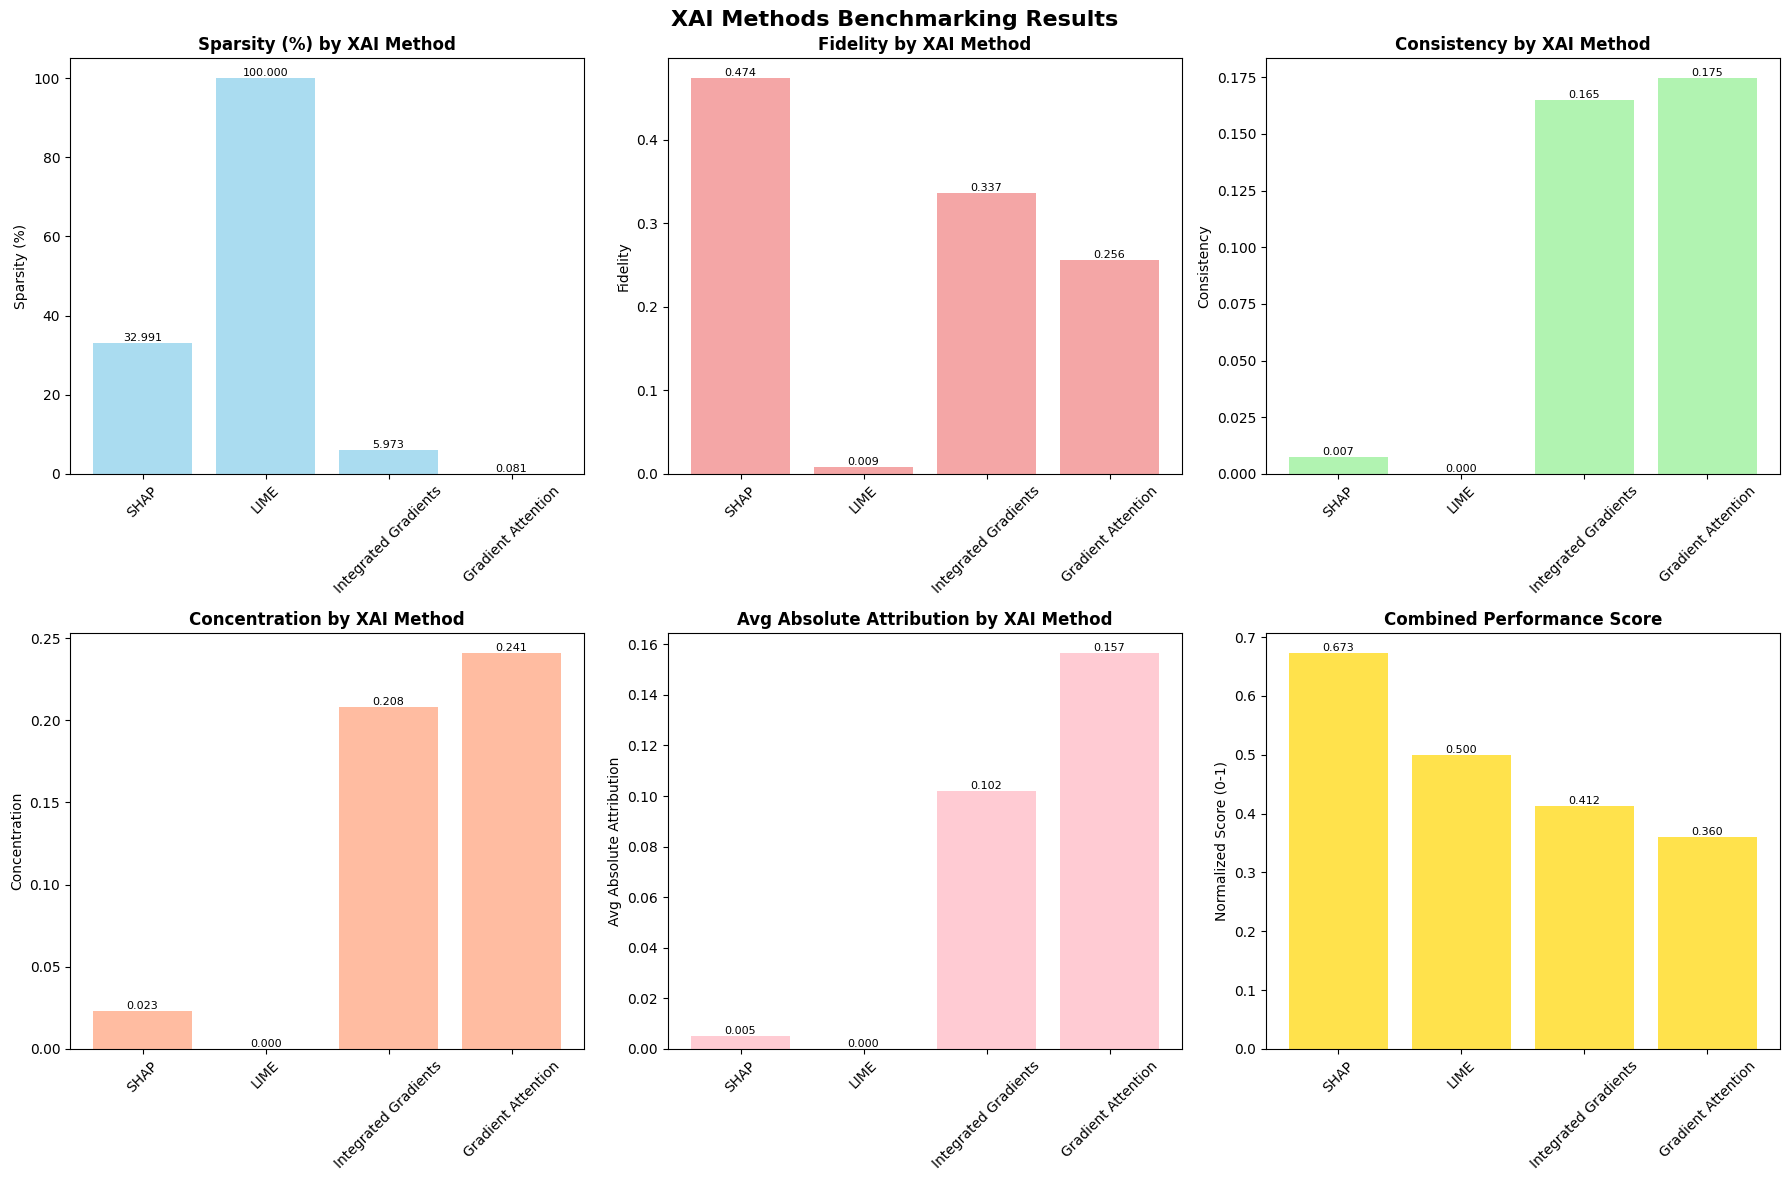


📊 Creating feature group importance comparison...


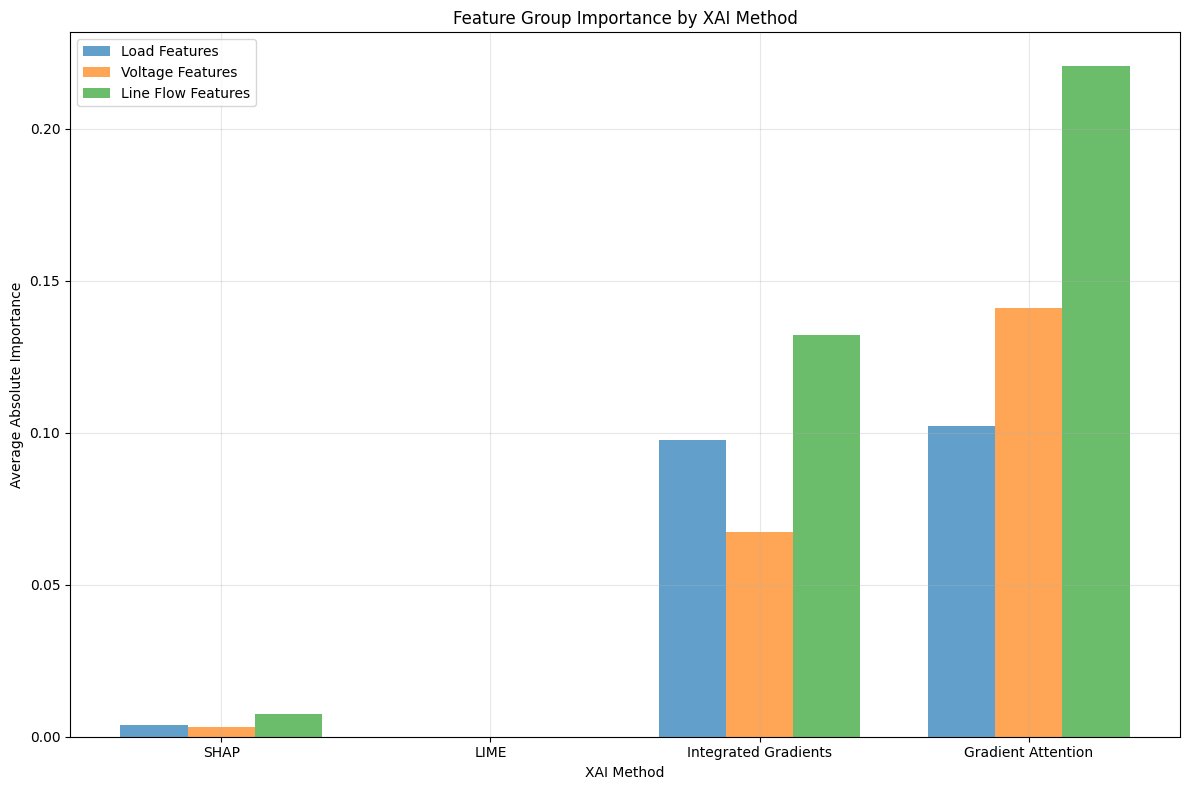


✅ Detailed results saved to 'detailed_xai_benchmarking.xlsx'
✅ Visualizations saved as PNG files


In [17]:
# Visualization of benchmarking results
print("📊 Creating visualizations...")

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('XAI Methods Benchmarking Results', fontsize=16, fontweight='bold')

metrics = ['Sparsity (%)', 'Fidelity', 'Consistency', 'Concentration', 'Avg Absolute Attribution']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightpink']

# Individual metric plots
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    bars = ax.bar(results_df['Method'], results_df[metric], color=colors[i % len(colors)], alpha=0.7)
    ax.set_title(f'{metric} by XAI Method', fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Overall comparison radar chart (in the last subplot)
ax_radar = axes[1, 2]
ax_radar.remove()  # Remove the last subplot

# Create a combined score visualization
ax_combined = fig.add_subplot(2, 3, 6)

# Normalize metrics to 0-1 scale for fair comparison
normalized_results = results_df.copy()
for col in ['Sparsity (%)', 'Fidelity', 'Consistency', 'Concentration', 'Avg Absolute Attribution']:
    max_val = normalized_results[col].max()
    min_val = normalized_results[col].min()
    if max_val != min_val:
        normalized_results[col] = (normalized_results[col] - min_val) / (max_val - min_val)
    else:
        normalized_results[col] = 0.5

# For some metrics, lower is better (invert them)
normalized_results['Consistency'] = 1 - normalized_results['Consistency']  # Lower consistency is better

# Calculate combined score
normalized_results['Combined Score'] = (
    normalized_results['Sparsity (%)'] * 0.2 +
    normalized_results['Fidelity'] * 0.3 +
    normalized_results['Consistency'] * 0.3 +
    normalized_results['Concentration'] * 0.2
)

bars_combined = ax_combined.bar(normalized_results['Method'], normalized_results['Combined Score'], 
                               color='gold', alpha=0.7)
ax_combined.set_title('Combined Performance Score', fontweight='bold')
ax_combined.set_ylabel('Normalized Score (0-1)')
ax_combined.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars_combined:
    height = bar.get_height()
    ax_combined.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('xai_benchmarking_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance comparison for power system specific features
print("\n📊 Creating feature group importance comparison...")

# Group features by type
load_indices = list(range(40))  # P and Q loads
voltage_indices = list(range(40, 40 + len(bus_cols)))
flow_indices = list(range(40 + len(bus_cols), len(feature_names)))

feature_groups = {
    'Load Features': load_indices,
    'Voltage Features': voltage_indices, 
    'Line Flow Features': flow_indices
}

group_importance = []

# Fix: Extract attributions correctly from methods dictionary
for method_name, method_data in methods.items():
    attributions = method_data['attributions']  # Extract attributions from the dictionary
    method_importance = {'Method': method_name}
    
    for group_name, indices in feature_groups.items():
        if len(indices) > 0 and max(indices) < attributions.shape[1]:
            group_attrs = attributions[:, indices]
            avg_importance = np.mean(np.abs(group_attrs))
            method_importance[group_name] = avg_importance
        else:
            method_importance[group_name] = 0
    
    group_importance.append(method_importance)

group_df = pd.DataFrame(group_importance)

# Plot feature group importance
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(group_df['Method']))
width = 0.25

for i, group in enumerate(['Load Features', 'Voltage Features', 'Line Flow Features']):
    ax.bar(x + i*width, group_df[group], width, label=group, alpha=0.7)

ax.set_xlabel('XAI Method')
ax.set_ylabel('Average Absolute Importance')
ax.set_title('Feature Group Importance by XAI Method')
ax.set_xticks(x + width)
ax.set_xticklabels(group_df['Method'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xai_feature_group_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save detailed results
with pd.ExcelWriter("detailed_xai_benchmarking.xlsx", engine='xlsxwriter') as writer:
    results_df.to_excel(writer, sheet_name="Overall_Results", index=False)
    group_df.to_excel(writer, sheet_name="Feature_Group_Importance", index=False)
    normalized_results.to_excel(writer, sheet_name="Normalized_Scores", index=False)

print("\n✅ Detailed results saved to 'detailed_xai_benchmarking.xlsx'")
print("✅ Visualizations saved as PNG files")

In [18]:
# Summary and Recommendations
print("\n🎯 XAI Benchmarking Summary and Recommendations")
print("=" * 60)

# Find best method for each metric
best_methods = {}
for metric in ['Sparsity (%)', 'Fidelity', 'Combined Score']:
    if metric == 'Consistency':  # Lower is better
        best_idx = results_df[metric].idxmin()
    else:  # Higher is better
        if metric == 'Combined Score':
            best_idx = normalized_results[metric].idxmax()
        else:
            best_idx = results_df[metric].idxmax()
    
    if metric == 'Combined Score':
        best_methods[metric] = normalized_results.loc[best_idx, 'Method']
    else:
        best_methods[metric] = results_df.loc[best_idx, 'Method']

print("🏆 Best Performing Methods:")
for metric, method in best_methods.items():
    print(f"  • {metric}: {method}")

print("\n📋 Method Characteristics:")
print("  • SHAP: Model-agnostic, theoretically grounded, good for global insights")
print("  • LIME: Local explanations, intuitive, fast computation")
print("  • Integrated Gradients: Attribution method, smooth gradients, requires gradients")
print("  • Gradient Attention: Simple, fast, but may be noisy")

print("\n💡 Recommendations for Power System Applications:")
if 'SHAP' in list(best_methods.values()):
    print("  ✅ SHAP recommended for comprehensive analysis and regulatory compliance")
if 'LIME' in list(best_methods.values()):
    print("  ✅ LIME recommended for real-time operational explanations")
if 'Integrated Gradients' in list(best_methods.values()):
    print("  ✅ Integrated Gradients recommended for deep learning model analysis")

print("\n🎯 Phase 4 Complete: XAI benchmarking analysis finished!")
print("📁 Outputs:")
print("   - xai_benchmarking_results.xlsx: Summary metrics")
print("   - detailed_xai_benchmarking.xlsx: Comprehensive results")
print("   - xai_benchmarking_comparison.png: Performance comparison charts")
print("   - xai_feature_group_importance.png: Feature importance by group")


🎯 XAI Benchmarking Summary and Recommendations
🏆 Best Performing Methods:
  • Sparsity (%): LIME
  • Fidelity: SHAP
  • Combined Score: SHAP

📋 Method Characteristics:
  • SHAP: Model-agnostic, theoretically grounded, good for global insights
  • LIME: Local explanations, intuitive, fast computation
  • Integrated Gradients: Attribution method, smooth gradients, requires gradients
  • Gradient Attention: Simple, fast, but may be noisy

💡 Recommendations for Power System Applications:
  ✅ SHAP recommended for comprehensive analysis and regulatory compliance
  ✅ LIME recommended for real-time operational explanations

🎯 Phase 4 Complete: XAI benchmarking analysis finished!
📁 Outputs:
   - xai_benchmarking_results.xlsx: Summary metrics
   - detailed_xai_benchmarking.xlsx: Comprehensive results
   - xai_benchmarking_comparison.png: Performance comparison charts
   - xai_feature_group_importance.png: Feature importance by group
